### Preparation

In [1]:
import os
os.chdir('/Users/pauls/Documents/CartPoleSimulation')
from SI_Toolkit.TF.TrainingData import get_training_files
from SI_Toolkit.TF.CustomTraining import CustomMSE

import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
model = keras.Sequential()
model.add(layers.Input(shape=(520, 6)))
model.add(layers.GRU(units=32, return_sequences=True))
model.add(layers.GRU(units=32, return_sequences=True))
model.add(layers.Dense(units=6, activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 520, 32)           3840      
                                                                 
 gru_1 (GRU)                 (None, 520, 32)           6336      
                                                                 
 dense (Dense)               (None, 520, 6)            198       
                                                                 
Total params: 10,374
Trainable params: 10,374
Non-trainable params: 0
_________________________________________________________________


In [30]:
model1 = keras.Sequential()
model1.add(layers.Input(shape=(520, 6)))
model1.add(layers.Dense(units=96, activation='tanh'))
model1.add(layers.Dense(units=96, activation='tanh'))
model1.add(layers.Dense(units=6, activation='linear'))
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 520, 96)           672       
                                                                 
 dense_2 (Dense)             (None, 520, 96)           9312      
                                                                 
 dense_3 (Dense)             (None, 520, 6)            582       
                                                                 
Total params: 10,566
Trainable params: 10,566
Non-trainable params: 0
_________________________________________________________________


In [3]:
def evaluate(model, test_set):
    model.compile(loss=CustomMSE(500, 20))
    print("Evaluate on test data")
    result = model.evaluate(test_set)
    return result


def plot_example(model, output, batch, test_set, save, save_name):
    # inputs = ['Q', 'angleD', 'angle_cos', 'angle_sin', 'position', 'positionD']
    # outputs = ['angleD', 'angle_cos', 'angle_sin', 'pole_length', 'position', 'positionD']

    inputs, labels = test_set[batch]  # shape = (16, 520, 6)
    test_sample = random.randint(0, 15)
    predictions = model.predict(inputs)
    results = pd.DataFrame(
        data={'Predictions': predictions[test_sample, :, output], 'Labels': labels[test_sample, :, output]})

    time = np.arange(1, 521)
    plt.figure(dpi=100)
    plt.rc('font', size=10)
    if output < 3:
        plt.plot(inputs[test_sample, :501, output + 1], marker='.', label='Inputs', markersize=4)
        plt.ylabel('feature')
    elif output > 3:
        plt.plot(inputs[test_sample, :501, output], marker='.', label='Inputs', markersize=4)
        plt.ylabel('feature')
    elif output == 3:
        plt.figure(dpi = 200, figsize=(6,7))
        plt.ylim(0.1, 0.5)
        plt.hlines(0.395, 0, 520, linewidth = 0.7, color='blue')
        plt.hlines(0.1975, 0, 520, linewidth = 0.7, color='blue')
        plt.ylabel('half pole length [m]')
    plt.scatter(time, results['Predictions'], marker='X', linewidth = 0.2,color='darkorange', s=10, label='Predictions')
    plt.scatter(time[500:], results['Labels'][500:], color='green', s=5, label='Labels')
    plt.xlabel('timestep [0.02s]')
    plt.legend()
    plt.grid()
    if save:
        plt.savefig('./Experiment_Recordings/Pole Length Predictions/' + save_name + '.png')
    plt.show()

    return results

### Plotting

In [4]:
import sys
sys.argv = ['']
training_dataset, validation_dataset, test_dataset = get_training_files()

  0%|          | 0/720 [00:00<?, ?it/s]

Loading data files:


  0%|          | 0/171 [00:00<?, ?it/s]

Loading data files:


  0%|          | 0/9 [00:00<?, ?it/s]

Loading data files:


100%|██████████| 9/9 [00:00<00:00, 30.65it/s]


In [9]:
from SI_Toolkit.TF.Autoregressive_Model import FeedBack
model2 = FeedBack(32, 6, 500)
path = './SI_Toolkit_ApplicationSpecificFiles/Experiments/L395-790-1/'
model2_name = 'Models/ARM-6IN-32H1-32H2-6OUT-0'
model2.load_weights(path + model2_name + '/ckpt.ckpt').expect_partial()

In [5]:
path = './SI_Toolkit_ApplicationSpecificFiles/Experiments/L395-790-2/'
model_name = 'Models/GRU-6IN-32H1-32H2-6OUT-0'
model.load_weights(path + model_name + '/ckpt.ckpt').expect_partial()

In [33]:
evaluate(model1, test_dataset)

Evaluate on test data
92/92 [==============================] - 4s 39ms/step - loss: 0.0012


0.0011916914954781532

<Figure size 600x400 with 0 Axes>

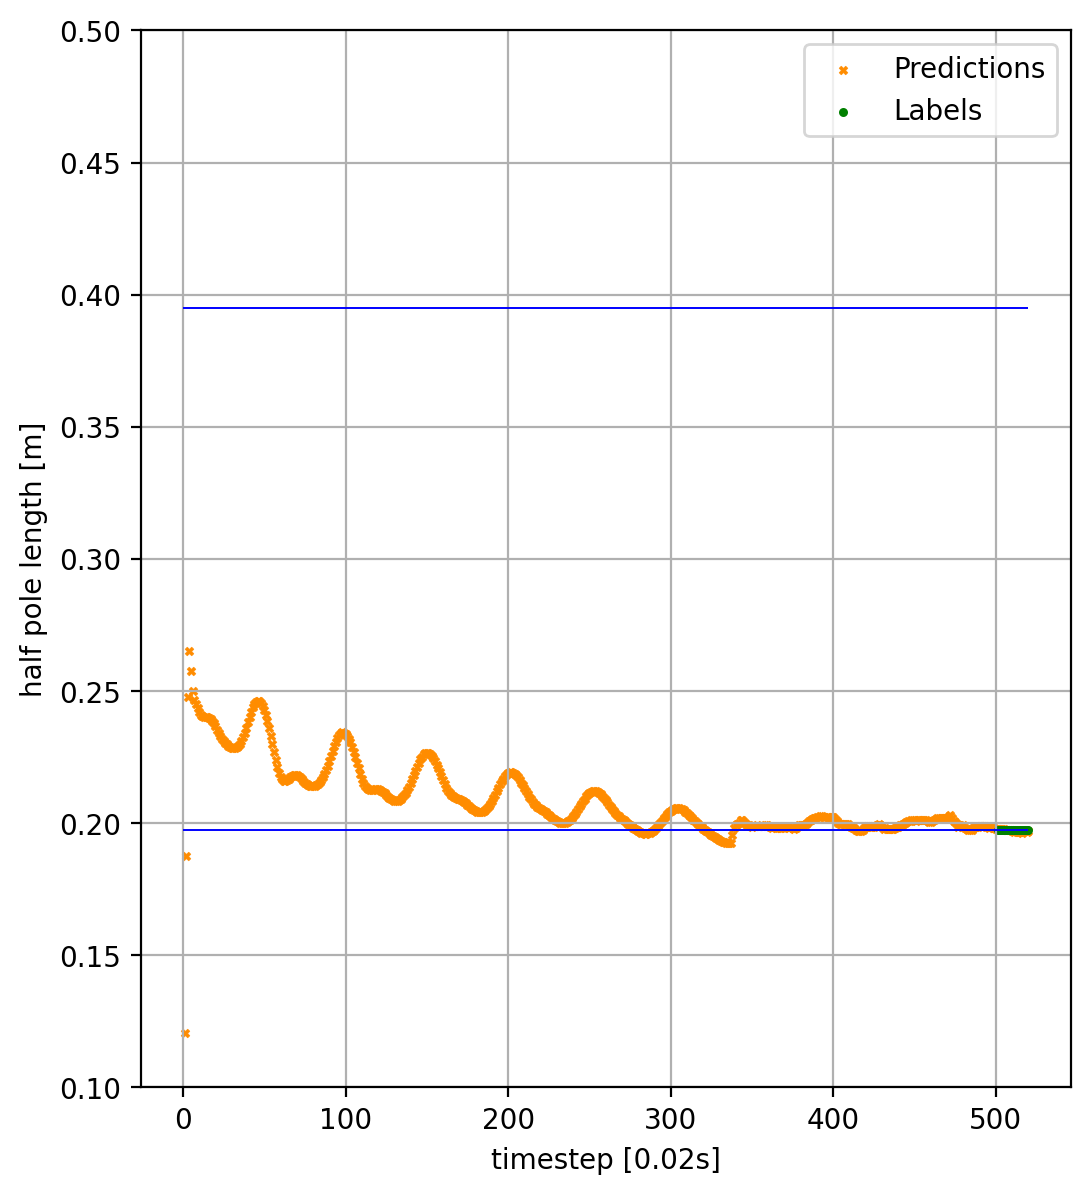

In [7]:
results = plot_example(model, 3, 10, test_dataset, save=False, save_name = 'pole_length GRU network L395')